# Spam Classification

In this project, we aim to classify Short Text Messages (SMS) as **spam** or **not spam**. This is a common text classification problem that has practical applications in filtering unwanted messages.

---

## Objectives

- **Develop a robust classifier:** Explore different machine learning models to determine the most effective one for spam detection.
- **Evaluate model performance:** Use cross-validation to assess each model’s accuracy and reliability.
- **Deploy the best model:** Select the model with the highest performance for further use.

---

## Dataset Overview

The dataset contains a collection of SMS messages, each accompanied by a label indicating whether the message is spam (`spam`) or not (`ham`). 

- **Message Text:** The content of the SMS.
- **Label:** Indicates whether the message is spam or not.

## Methodology

1. **Data Exploration & Preprocessing:** 
   - Inspect the dataset for inconsistencies and missing values.
   - Clean and preprocess text data to enhance model performance.

2. **Model Training & Evaluation:**
   - Train multiple models using the processed dataset.
   - Use cross-validation techniques to evaluate each model’s performance.
   - Compare metrics such as accuracy, precision, recall, and F1-score.

3. **Model Selection:**
   - Choose the best-performing model based on cross-validation scores.
   - Fine-tune the selected model if necessary.


## Imports

First we import all the tools we will need:

In [60]:
import string
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

## Read Data Set

Let's read the data set into a data frame and checkout 5 random rows to get an idea of what our data looks like:

In [43]:
df = pd.read_table('data/SMSSpamCollection', header=None, names=['label', 'message'])
df.sample(5)

,label,message
1861,ham,"It could work, we'll reach a consensus at the ..."
4525,ham,I've sent ü my part..
2140,ham,But i juz remembered i gotta bathe my dog today..
608,ham,what I meant to say is cant wait to see u agai...
3252,ham,"I‘ll leave around four, ok?"


## Prepare Labels

We can see the the `label` column is either `ham` or `spam`. Let's convert the string label column to `1` or `0` to prepare the dataset for a binary classification. 
- Positive class `1` indicates the message is a spam.
- Negative class `0` indicates the message is not spam.

In [44]:
df["label"] = df["label"].map({"ham": 0, "spam": 1})
df.sample(5)

,label,message
5518,0,"By the way, i've put a skip right outside the ..."
4791,0,Yup. Izzit still raining heavily cos i'm in e ...
3094,0,staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323
1962,0,LOL that would be awesome payback.
3037,0,;-) ok. I feel like john lennon.


## Prepare Messages

Let's do some preprocessing on text messages to ensure we remove useless parts such as puncutations or digits as by intuition we know that these are probably not very useful when determing if a message is spam or not.  We also lowercase all the text and remove extra whitespace.

In [45]:
def clean_text(text):
    # remove punctuation
    text = text.translate(text.maketrans('','', string.punctuation))

    # remove digits
    text = text.translate(text.maketrans('','', string.digits))

    # lowercase
    text = text.lower()

    # trim
    text = text.strip()
    
    return text

df["message"] = df["message"].apply(clean_text)
df.sample(5)

,label,message
2474,0,ok lor wat time ü finish
2165,0,nothing really just making sure everybodys up ...
3056,1,eastenders tv quiz what flower does dot compar...
5162,0,just send a text well skype later
4738,0,nt only for driving even for many reasons she ...


## Define Models

We are ready to define our models. We will test all the following models to see which one is doing better.


| **Model**                         | **Description**                                                                                                                                             | **When It Excels**                                                                                                                                       | **Considerations**                                                                                                                                           |
|-----------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Logistic Regression**           | A linear model that uses a logistic function to model binary (or multi-class) outcomes.                                                                      | - Linearly separable data<br>- Scenarios where interpretability is important<br>- Low to moderate dimensionality                                           | - May struggle with complex, non-linear relationships<br>- Regularization (L1/L2) is often needed to prevent overfitting                                  |
| **Multinomial Naive Bayes**       | A probabilistic classifier based on Bayes’ theorem with the assumption of feature independence, well-suited for discrete count data.                         | - Text classification (e.g., spam detection, document classification)<br>- High-dimensional, sparse data (e.g., word counts)                                | - The independence assumption may be unrealistic for some datasets<br>- Best for count-based features                                                     |
| **Random Forest Classifier**      | An ensemble method that builds multiple decision trees using bootstrapped samples and random feature selection to improve prediction accuracy and robustness. | - Capturing complex, non-linear relationships<br>- Situations requiring robust performance and reduced overfitting<br>- Feature importance estimation      | - Can be computationally intensive, especially with many trees<br>- Less interpretable than simpler linear models                                          |
| **Linear SVC**                    | A Support Vector Machine variant that finds the optimal linear hyperplane for class separation by maximizing the margin between classes.                     | - High-dimensional datasets (e.g., text data)<br>- Large-scale problems where speed is important<br>- Data with a clear linear margin between classes      | - Not suited for non-linear data unless a kernel is applied (which changes the model)<br>- Requires careful tuning of the regularization parameter (C)      |
| **K-Nearest Neighbors (KNN)**     | A non-parametric, instance-based algorithm that classifies new data points based on the majority vote among the 'K' closest examples in the feature space. | - Simple, intuitive classification tasks<br>- Data with complex, non-linear decision boundaries when a proper K and distance metric are chosen<br>- Small datasets | - Prediction time can be slow for large datasets<br>- Sensitive to the choice of K and the distance metric<br>- Performance may degrade in high-dimensional spaces (curse of dimensionality) |


In [48]:
models = [
    LogisticRegression(max_iter=1000),
    MultinomialNB(),
    RandomForestClassifier(),
    LinearSVC(),
    KNeighborsClassifier()
]

## Training Models

We will use the `cross_val_score` function the run cross validation tests on different models, saving the accuracy score for various models in our `results` array.

In [50]:
results = []
for model in models:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95)),
        ('clf', model)
    ])

    scores = cross_val_score(pipeline, df["message"], df["label"], scoring="accuracy", cv=5)
    results.append(scores)

## Plot Results

Now let's create a plot of the scores to see which model is doing better:

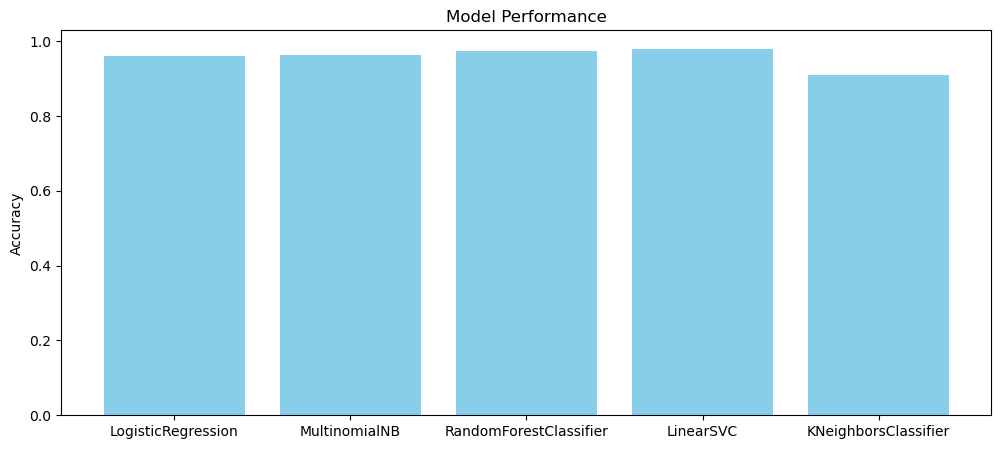

In [51]:
plt.figure(figsize=(12, 5));
plt.bar(["LogisticRegression", "MultinomialNB", "RandomForestClassifier", "LinearSVC", "KNeighborsClassifier"] ,np.mean(results, axis=1), color="skyblue")
plt.title("Model Performance");
plt.ylabel("Accuracy");

## Select Best Model

Using the plot above, we can see that the `LinearSVC` model is peforming better than others, while `KNeighborsClassifier` is the worst among all the models. So let's select that as our model and check out some additional metrics:

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.3)

best_estimator = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95)),
    ('clf', LinearSVC())
])

best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)

In [55]:
accuracy_score(y_test, y_pred)

0.9784688995215312

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1462
           1       0.97      0.85      0.91       210

    accuracy                           0.98      1672
   macro avg       0.98      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



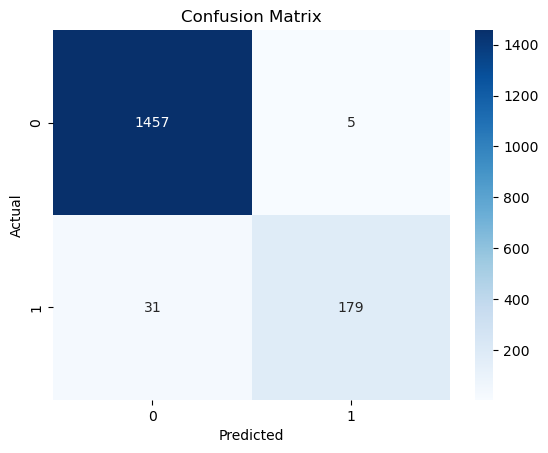

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Learning Curve

Let's also take a look at the learning curve over training set size. As we can see in the plot below, the performance of model improves significantly as the training size increases from `500` to `1500`, but after that it stays pretty much linear.

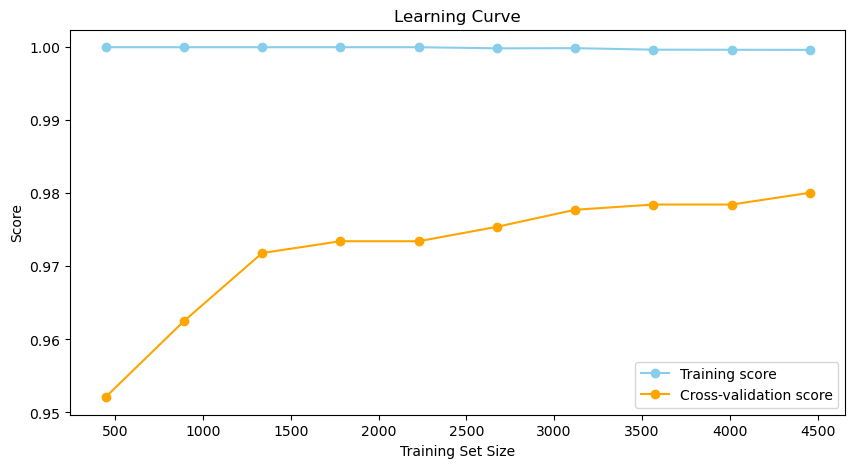

In [59]:
train_sizes, train_scores, test_scores = learning_curve(
    best_estimator, df["message"], df["label"], cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training score', c="skyblue")
plt.plot(train_sizes, test_mean, 'o-', label='Cross-validation score', c="orange")
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

## Better / Simplified Implementation

Instead of calcuating the cross validation scores, graphing, and finding the best model manually, we can make use of sklearn's `GridSearchCV` which helps us find the best model easily.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=.2)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())  # Dummy initialization; actual classifier will be set by GridSearchCV
])


param_grid = [
    {
        'tfidf__max_df': [0.8, 1.0],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf': [LogisticRegression(max_iter=1000)],
        'clf__C': [0.1, 1, 10]
    },
    {
        'tfidf__max_df': [0.8, 1.0],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf': [MultinomialNB()],
        'clf__alpha': [0.5, 1.0]
    },
    {
        'tfidf__max_df': [0.8, 1.0],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf': [LinearSVC()],
        'clf__C': [0.1, 1, 10],
        'clf__max_iter': [1000, 1500]
    },
    {
        'tfidf__max_df': [0.8, 1.0],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'clf': [RandomForestClassifier(n_estimators=100, random_state=42)],
    }
]


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report for the Best Model:")
print(classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'clf': LinearSVC(), 'clf__C': 1, 'clf__max_iter': 1000, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Accuracy: 0.9829465557417725

Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       961
           1       1.00      0.90      0.95       154

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Test Accuracy: 0.9865470852017937


# Neural Networks

As we saw above, our model is doing really well already. However, let's also try training a nueral network to see if it can perform just as good or better. We will use Tensorflow for this.

Let's import the additional tools we will need: